# Wheelchair Control

![](images/wheelchair.jpg)

### Python Dependencies

In [1]:
from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *
from matplotlib.transforms import Affine2D

from math import * 

Step 1 - Wheelchair Planar Model
================================

### Introduction

We consider a simple model of a wheelchair evolving in the plane. It is mainly made of

  - A frame ; from above, its most visible component is the seat. We assume that it is a square,

  - Two fixed wheels (their orientation with respect to the frame does not change). 
    They are parallel and located at opposite ends of the seat. 
    
We assume that the seat backrest is on top of the wheels common axis.


Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote 

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and 
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the wheelchait faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the wheelchair moves forward.

### Parameter Definition

From now on, we assume that the seat side length is $L = 50 \mbox{ cm}$ and the wheel radius is $R_w = 30 \mbox{ cm}$.

🧩 Define the corresponding Python variables `L` and `Rw` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values.

<span style=color:red>**Vous utilisez `R_w` au lieu de `Rw`... ça génère une erreur plus loin dans le code, dommage...** </span>

In [2]:
L = 50*10**(-2)
R_w = 30*10**(-2)

### Graphical Representation

🧩 Implement a function `draw_wheelchair` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with seat and fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. 

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

In [3]:
def draw_wheelchair(x, y, theta, ax):
    
    # theta en rad     
    seat_corners = array([
        [x - L/2, y ],
        [x + L/2, y ],
        [x + L/2, y + L],
        [x - L/2, y + L],
    ])    
    
    #seat
    square = Polygon(seat_corners)
    ax.add_patch(square)
    
    transf = Affine2D().rotate_around(x, y, theta - pi/2)
    square.set_transform(transf + ax.transData)
    

    rot_matrix = array([
    [cos(theta - pi/2), -sin(theta - pi/2)],
    [sin(theta - pi/2), cos(theta - pi/2)]
])
    
    #wheel1
    x1_1 = x - L/2 
    y1_1 = y - R_w
    
    x2_1 = x - L/2
    y2_1 = y + R_w
    
    x1r_1 , y1r_1 = (rot_matrix.dot(array([x1_1 - x, y1_1 - y]))).T + (x, y)
    x2r_1 , y2r_1 = (rot_matrix.dot(array([x2_1 - x, y2_1 - y]))).T + (x, y)
        
    ax.plot([x1r_1, x2r_1], [y1r_1, y2r_1], linewidth = 5, color = 'black')
    
    #wheel2
    x1_2 = x + L/2
    y1_2 = y - R_w
    
    x2_2 = x + L/2
    y2_2 = y + R_w
    
    
    x1r_2 , y1r_2 = (rot_matrix.dot(array([x1_2 - x, y1_2 - y]))).T + (x, y)
    x2r_2 , y2r_2 = (rot_matrix.dot(array([x2_2 - x, y2_2 - y]))).T + (x, y)
        
    ax.plot([x1r_2, x2r_2], [y1r_2, y2r_2], linewidth = 5, color = 'black')

🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [4]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 10, 10 / wh_ratio
    figure(figsize=figsize)
    ax = gca()
    ax.axis([xmin, xmax, ymin, ymax])
    ax.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)
    return ax

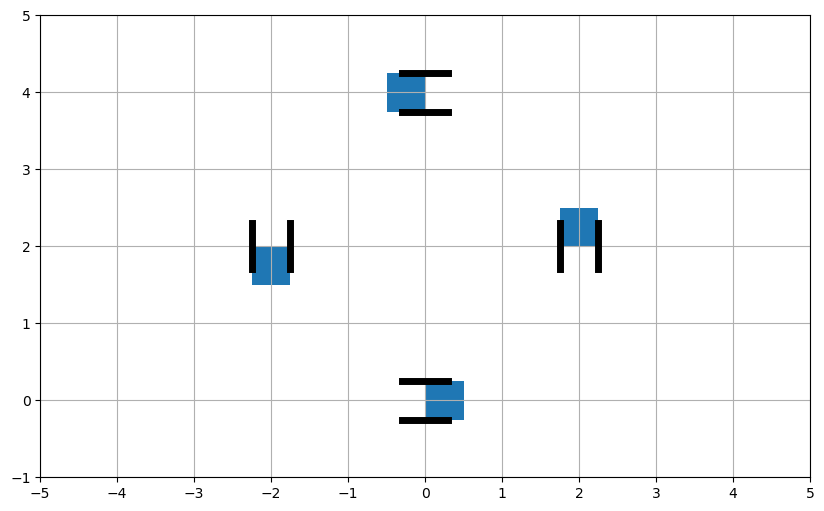

In [5]:
ax = draw_arena(-5, 5, -1,5)
draw_wheelchair(0, 0, 0, ax)
draw_wheelchair(2, 2, pi/2, ax)
draw_wheelchair(0, 4, pi, ax)
draw_wheelchair(-2, 2, 3*pi/2, ax)

### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping. 

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

**Answer:**

La condition de roulement sans glissement appliquée aux deux roues donne :\
    $$\vec{v}(O_r) = R_{\omega}\omega_r\vec{e}_\theta$$ et $$\vec{v}(O_l) = R_{\omega}\omega_l\vec{e}_\theta$$ \
Avec $O_r$ et $O_l$ respectivement les centres des roues droite et gauche 

D'autre part, la vitesse du point G (centre de l'axe communs des roues) peut s'écrire de deux manières : \
$$\vec{v}_G = \vec{v}_{O_r} + \vec{GO_r} \wedge \dot{\theta} \times\vec{e}_z $$  (1) 
$$\vec{v}_G = \vec{v}_{O_l} + \vec{GO_l} \wedge \dot{\theta} \times\vec{e}_z $$  (2)   
Ce qui donne : $$\vec{v}_G = \frac{1}{2}(\vec{v}_{O_r} + \vec{v}_{O_l})$$\
Finalement : \
$$\dot{x} = -\frac{1}{2}R(\omega_l + \omega_r)\cos{\theta}$$
$$\dot{y} = \frac{1}{2}R(\omega_l + \omega_r)\sin{\theta}$$\
On fait la différence entre les deux equations (1) et (2) et on projettant la relation vectorielle obtenue on obtient l'équation dfférentielle de $\theta$ suivante :\
$$\dot{\theta} = \frac{1}{L}(v_{O_l} - v_{O_r})$$\
D'où : $$\dot{\theta} = \frac{R_\omega}{L}(\omega_{l} - \omega_{r})$$

<span style=color:red>**Erreur de signe sur $\dot{x}$** </span>

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

**Answer:**

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

**Answer:**

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

In [6]:
def omega(t, xytheta):
    omega_l = (1 - L/4) * pi / Rw
    omega_r = (1 + L/4) * pi / Rw
    return array([omega_l, omega_r])

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

<span style=color:red>**La défintion de `fun` est cohérente avec l'erreur de signe dans la partie théorique. Par contre, vous avez une erreur à l'exécution due à votre utilisation de `R_w` alors que le code fourni pour `omega` respecte bien la convention demandée initialement...**</span>

In [7]:
def fun(t, xytheta):
    x, y, theta = xytheta
    om = omega(t, xytheta)
    x_point = -1/2*R_w*(om[0] + om[1])*cos(theta)
    y_point = 1/2*R_w*(om[0] + om[1])*sin(theta)
    theta_point = R_w/L*(om[0] - om[1])
    
    return x_point, y_point, theta_point

In [8]:
fun(1, (2, 2, pi))

NameError: name 'Rw' is not defined

### Simulation Setup

🧩 Simulate the wheelchair dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - L/4)  \pi / R \mbox{ rad/s}$ and $\omega_r = (1 + L/4)  \pi / R_w \mbox{ rad/s}$.
(Compute the dense outputs.)
   

In [ ]:
pass

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

In [ ]:
pass

🧩 Use the simulation results to display the robot location every 0.5 second.

In [ ]:
pass

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$? 

**Answer:**

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

In [ ]:
pass

🧩 If needed, adjust the simulation parameters until this error is uniformly less than $2 \times 10^{-5}$ for every component of $(x, y, \theta)$.

In [ ]:
pass